# Signal processing on large datasets (FFT)
In the previous notebook, [Signal Analysis with Fourier Transform](./discrete_fourier_transform.ipynb) we looked at how we can use the discrete Fourier transfer to analyze discrete signals.

However, the operations of the DFT uses $\mathcal{O}(N^2)$ operations, $N$ being the number of sample points.
In the case of [Banks et al.](https://doi.org/10.1109/AERO.2004.1368169), the signal is sampled with a frequency of $102.4\cdot 10^3$ Hz for $10$ seconds.
This means that each run takes in $1.02\cdot 10^6$ values, and that the dense matrix used in the DFT would have $\simeq 10^{12}$ entries. A straightforward calculation of the matrix vector product is not just memory intensive, but also a slow operation.

In the next snippet, we try to create a matrix for generating DFT for a signal like the one in Banks et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sampling_frequency = 102.4e3 # Hz
T = 10 # s
try:
    DFT_matrix = np.zeros((int(sampling_frequency*T), int(sampling_frequency*T)), dtype=np.float64)
except MemoryError as e:
    print(f"Crashed with the following error message:\n{e}")

Crashed with the following error message:
Unable to allocate 7.63 TiB for an array with shape (1024000, 1024000) and data type float64


Thus, we need a more efficient way of computing the Fourier transformation. We use the [Fast Fourier transformation](https://doi.org/10.2307/2003354) which have been implemented efficiently in many Python-libraries, such as
[numpy](https://numpy.org/doc/stable/reference/routines.fft.html), [scipy](https://docs.scipy.org/doc/scipy/tutorial/fft.html) and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/signal/fft). This algorithm reduced the number of floating point operations to $N\log N$. We illustrate the massive difference in number of operations as we let $N$ grow big

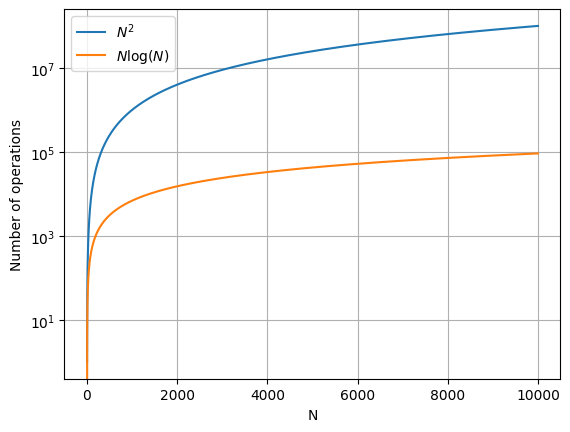

In [3]:
N = np.arange(1, 1e4, dtype=np.int32)
plt.plot(N, N**2, label=r"$N^2$")
plt.plot(N, N*np.log(N), label=r"$N\log(N)$")
plt.legend()
plt.ylabel("Number of operations")
plt.xlabel("N")
plt.gca().set_yscale("log")
plt.grid()
plt.show()

In this notebook, we will use `numpy` to compute the Fast Fourier transforms. We will exploit that the input signals are real-valued, and use [`numpy.fft.rfft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html).

## Noisy data-sets
In real-life, input data from sensors are affected by noise. We want to look at how we can use the Fourier Transform to filter out noise.
We start by adding noise with a standard distribution with mean zero, and variance one.

In [4]:
from ipywidgets import widgets
@widgets.interact(
    T=widgets.IntSlider(2, min=0, max=10, description="Simulation time (s)",style={'description_width': 'initial'}),
    sampling_rate=widgets.IntSlider(22, min=6, max=256, description="Sampling rate (Hz)"),
    frequency=widgets.IntSlider(3, min=0, max=128, description="Frequency of signal (Hz)", style={'description_width': 'initial'}),
    noise_A=widgets.FloatSlider(0.5, min=0, max=2, description="Amplitude of noise", style={'description_width': 'initial'})
    )
def compute_fft(T:float, sampling_rate:int, frequency:float, noise_A:float):
    """
    Compute the Discrete Fourier transformation  on a given interval with a given sampling rate
    """
    t = np.linspace(0, T, int(T*sampling_rate), endpoint=False)
    signal = np.cos(2*np.pi*t*frequency)
    noise = noise_A * np.random.randn(len(signal))
    noisy_signal = signal+noise
    fft = np.fft.rfft(noisy_signal, n=len(signal))
    frequencies = np.fft.rfftfreq(len(signal), 1./sampling_rate)
    print(f"Max frequency from FFT: {frequencies[np.argmax(np.abs(fft))]}")
    plt.figure()
    plt.subplot(121)
    plt.plot(t, signal, label="Signal")
    plt.plot(t, noisy_signal, label="Noisy signal")
    plt.xlabel("t")
    plt.ylabel(r"$x$")
    plt.legend()
    plt.subplot(122)
    plt.ylabel(r"$\hat x$")
    plt.xlabel(r"$f$")
    plt.stem(frequencies, np.abs(fft)/len(signal))
    plt.show()


interactive(children=(IntSlider(value=2, description='Simulation time (s)', max=10, style=SliderStyle(descript…

Using FFT, we can pick out the most dominant frequencies to filter out the noise.

## Exercises

1. Compute the Fourier transform for the signal above.

2. Extract the dominant frequency and phase to reconstruct the signal.

3. Try adding the $M$ most dominant frequencies from the Fourier transform, what happens?